In [16]:
%%capture
!pip install keras tensorflow seaborn requests-cache

In [17]:
import os
import sqlite3
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import requests
import requests_cache
from requests_cache.backends.sqlite import SQLiteCache
import sqlite3
import datetime
from datetime import date, timedelta, timezone
import time
import pytz

local_tz = pytz.timezone('America/New_York')


mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# initialize cache
requests_cache.install_cache('./data/weather_api_cache')

In [21]:


# API_KEY = os.env.get("API_KEY")
DATE_FORMAT = "%Y-%m-%d %H:%M:%S"
API_KEY = "e1f10a1e78da46f5b10a1e78da96f525"
BASE_URL = "https://api.weather.com/v1/location/KDCA:9:US/observations/historical.json?apiKey={api_key}&units=e&startDate={start_date}&endDate={end_date}"

# Field descriptions here
# https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/511371/1/LapamonpinyoEtAl_engrXiv_2021.pdf    
# Sample
# {
#     'key': 'KDCA', 'class': 'observation', 'expire_time_gmt': 946709460, 'obs_id': 'KDCA', 'obs_name': 'Washington/Natl', 
#     'valid_time_gmt': 946702260, 'day_ind': 'N', 'temp': 41, 'wx_icon': 33, 'icon_extd': 3300, 'wx_phrase': 'Fair', 'pressure_tend': None,
#     'pressure_desc': None, 'dewPt': 34, 'heat_index': 41, 'rh': 76, 'pressure': 30.19, 'vis': 5, 'wc': 41, 'wdir': None, 
#     'wdir_cardinal': 'CALM', 'gust': None, 'wspd': None, 'max_temp': 57, 'min_temp': 41, 'precip_total': None, 
#     'precip_hrly': None, 'snow_hrly': None, 'uv_desc': 'Low', 'feels_like': 41, 'uv_index': 0, 'qualifier': None, 'qualifier_svrty': None,
#     'blunt_phrase': None, 'terse_phrase': None, 'clds': 'CLR', 'water_temp': None, 'primary_wave_period': None, 'primary_wave_height': None, 
#     'primary_swell_period': None, 'primary_swell_height': None, 'primary_swell_direction': None, 'secondary_swell_period': None, 
#     'secondary_swell_height': None, 'secondary_swell_direction': None
# }

conn = sqlite3.connect("./data/weather-raw.db")
cur = conn.cursor()


def create_weather_table(cur, table_name):
    cur.execute("""
    CREATE TABLE IF NOT EXISTS {table_name}(
        key, class, expire_time_gmt, obs_id, obs_name, valid_time_gmt INTEGER NOT NULL PRIMARY KEY, day_ind, temp, wx_icon, icon_extd, 
        wx_phrase, pressure_tend, pressure_desc, dewPt, heat_index, rh, pressure, vis, wc, wdir, wdir_cardinal, 
        gust, wspd, max_temp, min_temp, precip_total, precip_hourly, snow_hrly, uv_desc, feels_like, uv_index,
        qualifier, qualifier_svrty, blunt_phrase, terse_phrase, clds, water_temp, primary_wave_period, 
        primary_wave_height, primary_swell_period, primary_swell_height, primary_swell_direction, 
        secondary_swell_period, secondary_swell_height, secondary_swell_direction, obs_timestamp)
    """.format(table_name=table_name))
    cur.execute("""
    CREATE INDEX idx_obs_timestamp ON weather_raw(obs_timestamp);
    """)
    cur.execute("""
    CREATE INDEX idx_obs_timestamp_month ON weather_raw(STRFTIME('%M', obs_timestamp));
    """)
    cur.execute("""
    CREATE INDEX idx_obs_timestamp_date ON weather_raw(STRFTIME('%Y-%m-%d', wr.obs_timestamp));
    """)
    
# Create tables for raw & cleaned data respectively (if they don't exist already)
create_weather_table(cur, "weather_raw")


# Get the latest date that data has been downloaded for and start downloading new data from that timestamp
cur.execute("SELECT MAX(obs_timestamp) FROM weather_raw")
max_date = cur.fetchone()[0]
target_date = datetime.datetime.strptime(max_date, DATE_FORMAT).date() if max_date else date(2000, 1, 1)

print(f"Starting Date: {target_date}")  
print("--------------------------------")
defaults = {
    'key': None,'class': None,'expire_time_gmt': None,'obs_id': None,'obs_name': None,'valid_time_gmt': None,
    'day_ind': None,'temp': None,'wx_icon': None,'icon_extd': None,'wx_phrase': None,'pressure_tend': None,
    'pressure_desc': None,'dewPt': None,'heat_index': None,'rh': None,'pressure': None,'vis': None,'wc': None,
    'wdir': None,'wdir_cardinal': None,'gust': None,'wspd': None,'max_temp': None,'min_temp': None,'precip_total': None,
    'precip_hrly': None,'snow_hrly': None,'uv_desc': None,'feels_like': None,'uv_index': None,'qualifier': None,
    'qualifier_svrty': None,'blunt_phrase': None,'terse_phrase': None,'clds': None,'water_temp': None,
    'primary_wave_period': None,'primary_wave_height': None,'primary_swell_period': None,'primary_swell_height': None,
    'primary_swell_direction': None,'secondary_swell_period': None,'secondary_swell_height': None,'secondary_swell_direction': None
}


INSERT_SQL = """
INSERT OR IGNORE INTO weather_raw VALUES (
    :key, :class, :expire_time_gmt, :obs_id, :obs_name, :valid_time_gmt, :day_ind, :temp, :wx_icon, :icon_extd, :wx_phrase,
    :pressure_tend, :pressure_desc, :dewPt, :heat_index, :rh, :pressure, :vis, :wc, :wdir, :wdir_cardinal,
    :gust, :wspd, :max_temp, :min_temp, :precip_total, :precip_hrly, :snow_hrly, :uv_desc, :feels_like, :uv_index,
    :qualifier, :qualifier_svrty, :blunt_phrase, :terse_phrase, :clds, :water_temp, :primary_wave_period,
    :primary_wave_height, :primary_swell_period, :primary_swell_height, :primary_swell_direction,
    :secondary_swell_period, :secondary_swell_height, :secondary_swell_direction, :obs_timestamp
)
"""

def augment_data(rec):
    rec["obs_timestamp"] = datetime.datetime.fromtimestamp(rec["valid_time_gmt"]).strftime(DATE_FORMAT)
    return rec

today = datetime.date.today()
if target_date == today:
    print("Already up to date!")
    
while target_date != today:
    end_date = target_date + timedelta(days=1) 
    start_date_str = target_date.strftime("%Y%m%d")
    end_date_str = end_date.strftime("%Y%m%d")
    target_url = BASE_URL.format(api_key=API_KEY, start_date=start_date_str, end_date=start_date_str)
    res = requests.get(target_url)
    target_date = end_date

    data = res.json()
    if not "observations" in data:
        print(f"Date: {target_date} NF", end="\r")
        continue
    params = ({k: d.get(k, defaults[k])  for k in defaults} for d in data["observations"])
    params = list(map(augment_data, params))

    cur.executemany(INSERT_SQL, params)
    conn.commit()
    # time.sleep(0.05)
    # was_cached = "Cache HIT" if res.from_cache else "Cache MISS"
    print(f"Date: {target_date} OK", end="\r")
    target_date = end_date

SQL_CLEANED_DATA = """
    WITH RECURSIVE generate_series(x) AS (
        SELECT 0
        UNION ALL
        SELECT x+1 FROM generate_series LIMIT 24
    ), distinct_dates AS (
        SELECT DISTINCT DATE(obs_timestamp) AS obs_date
        FROM weather_raw wr 
        WHERE obs_timestamp >= '2000-01-01'
    ), hours AS (
        SELECT x AS hrs FROM generate_series
    )
    SELECT w.temp, w.obs_timestamp, w.pressure, w.wspd
    FROM weather_raw w 
    JOIN (
        SELECT d.obs_date, COUNT(*)
        FROM distinct_dates d 
        CROSS JOIN hours h 
        INNER JOIN (SELECT * FROM weather_raw WHERE STRFTIME('%M', obs_timestamp) in ('51', '52')) wr 
            ON DATE(STRFTIME('%Y-%m-%d', wr.obs_timestamp)) = d.obs_date 
            AND CAST(STRFTIME('%H', obs_timestamp) AS INTEGER) = h.hrs
        GROUP BY d.obs_date
        HAVING COUNT(*) = 24
    ) d ON d.obs_date = STRFTIME('%Y-%m-%d', w.obs_timestamp) 
    WHERE STRFTIME('%M', w.obs_timestamp) in ('51', '52');
"""
df = pd.read_sql(SQL_CLEANED_DATA, conn, parse_dates=["obs_timestamp"])   
df.head() 

Starting Date: 2022-12-07
--------------------------------
Already up to date!


,temp,obs_timestamp,pressure,wspd
0,50.0,2000-01-02 00:51:00,30.22,NaN
1,45.0,2000-01-02 01:51:00,30.21,5.0
2,47.0,2000-01-02 02:51:00,30.21,5.0
3,46.0,2000-01-02 03:51:00,30.21,NaN
4,47.0,2000-01-02 04:51:00,30.20,5.0


In [22]:
def prepare_dataframe(_df):
  _df = _df.astype(
      {
          'temp': 'float',
          'pressure': 'float',
          'wspd': 'float'
      },
  )
  _df = _df.dropna()
  _df = _df.sort_values(by=['obs_timestamp'])
  date_time = _df.pop('obs_timestamp')
  timestamp_s = date_time.map(pd.Timestamp.timestamp)
  day = 24*60*60
  year = (365.2425)*day
  
  _df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
  _df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
  _df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
  _df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

  
  return _df, date_time

# Field descriptions here
# https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/511371/1/LapamonpinyoEtAl_engrXiv_2021.pdf  
df, date_time = prepare_dataframe(df)
df.head()

,temp,pressure,wspd,day_sin,day_cos,year_sin,year_cos
1,45.0,30.21,5.0,0.465615,0.884988,0.013798,0.999905
2,47.0,30.21,5.0,0.678801,0.734323,0.014514,0.999895
4,47.0,30.20,5.0,0.955020,0.296542,0.015948,0.999873
5,44.0,30.19,3.0,0.999229,0.039260,0.016664,0.999861
6,48.0,30.18,12.0,0.975342,-0.220697,0.017381,0.999849


/tmp/ipykernel_64/4039997715.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plot_features.index = date_time[-480:]


,count,mean,std,min,25%,50%,75%,max
temp,179231.0,59.138720,17.768787,6.000000,45.000000,60.000000,74.000000,118.000000
pressure,179231.0,30.034228,0.216623,28.610000,29.900000,30.030000,30.170000,30.860000
wspd,179231.0,8.984768,4.745124,0.000000,6.000000,8.000000,12.000000,45.000000
day_sin,179231.0,-0.015076,0.706559,-0.999391,-0.731354,-0.034899,0.681998,0.999391
day_cos,179231.0,0.007189,0.707461,-0.999391,-0.681998,0.034899,0.731354,0.999391
year_sin,179231.0,0.004124,0.709370,-1.000000,-0.705328,0.007787,0.717489,1.000000
year_cos,179231.0,-0.003987,0.704817,-1.000000,-0.708857,-0.004902,0.696913,1.000000


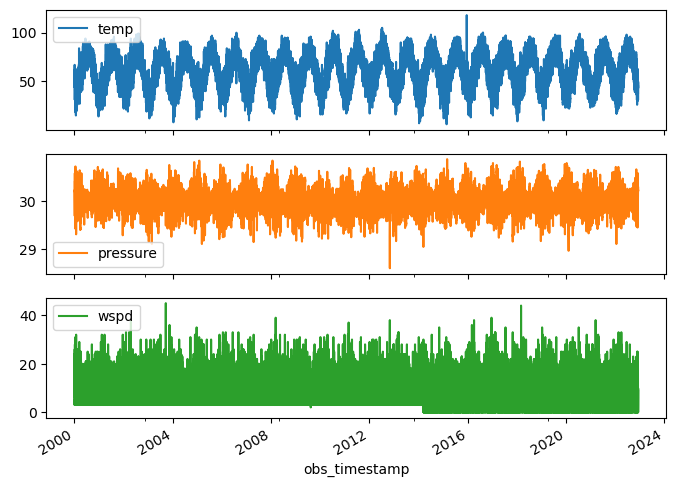

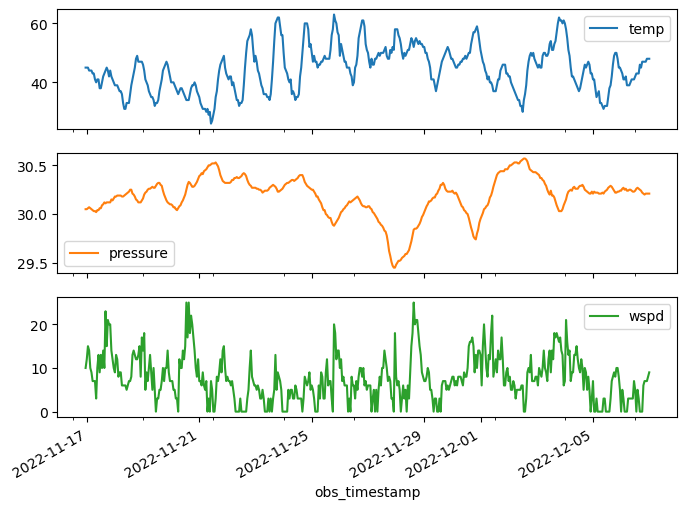

In [24]:
plot_cols = ['temp', 'pressure', 'wspd']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][-480:]
plot_features.index = date_time[-480:]
_ = plot_features.plot(subplots=True)
df.describe().transpose()

Text(0.5, 1.0, 'Year signal')

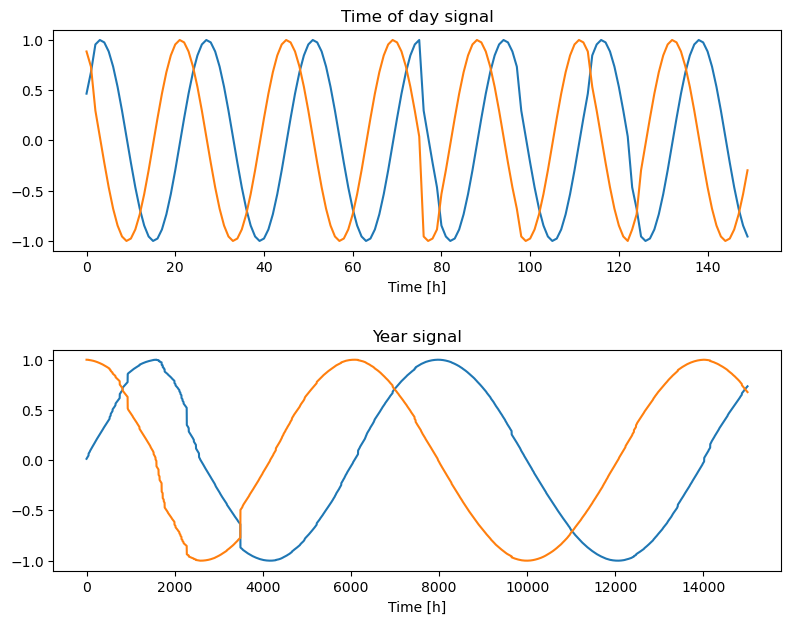

In [25]:
fig, axes = plt.subplots(2, 1)
fig.tight_layout(h_pad=5)
axes[0].plot(np.array(df['day_sin'])[:150])
axes[0].plot(np.array(df['day_cos'])[:150])
axes[0].set_xlabel('Time [h]')
axes[0].set_title('Time of day signal')

axes[1].plot(np.array(df['year_sin'])[:15000])
axes[1].plot(np.array(df['year_cos'])[:15000])
axes[1].set_xlabel('Time [h]')
axes[1].set_title('Year signal')

In [27]:
# Split data
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [28]:
# Normalization

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [36]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns="temp"):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels

  def plot(self, model=None, plot_col='temp', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [h]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

MAX_EPOCHS = 30

def compile_and_fit(model, window, patience=2, epochs=MAX_EPOCHS):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(
      loss=tf.keras.losses.MeanSquaredError(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=[tf.keras.metrics.MeanAbsoluteError()]
  )
  
  history = model.fit(window.train, epochs=epochs,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

Total window size: 192
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
Label indices: [168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191]
Label column name(s): ['temp']

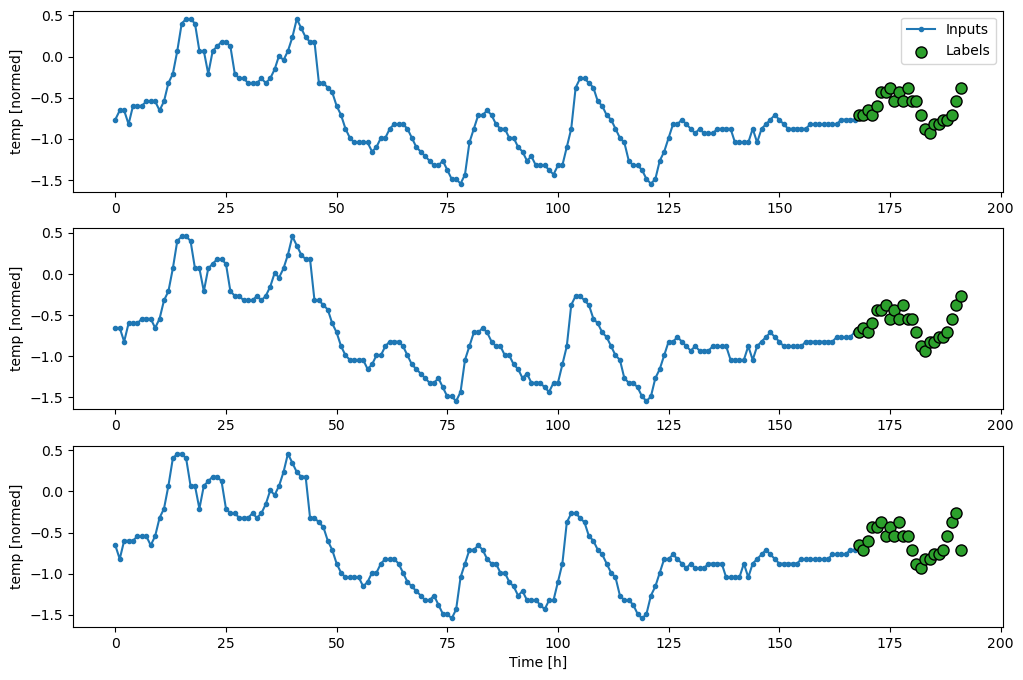

In [37]:
OUT_STEPS = 24
multi_window = WindowGenerator(
    input_width=168, label_width=OUT_STEPS, shift=OUT_STEPS,
    label_columns=['temp']
)
multi_window.plot()
multi_window

1115/1115 [==============================] - 4s 4ms/step - loss: 2.1419 - mean_absolute_error: 1.1699


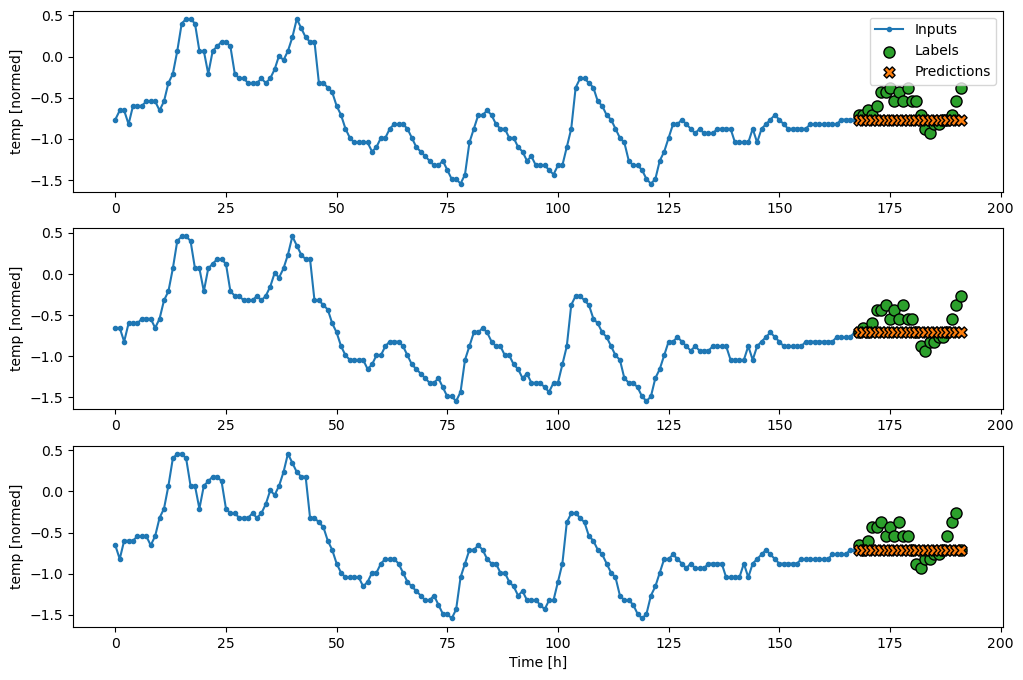

In [39]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

1119/1119 [==============================] - 6s 5ms/step - loss: 2.1284 - mean_absolute_error: 1.1630


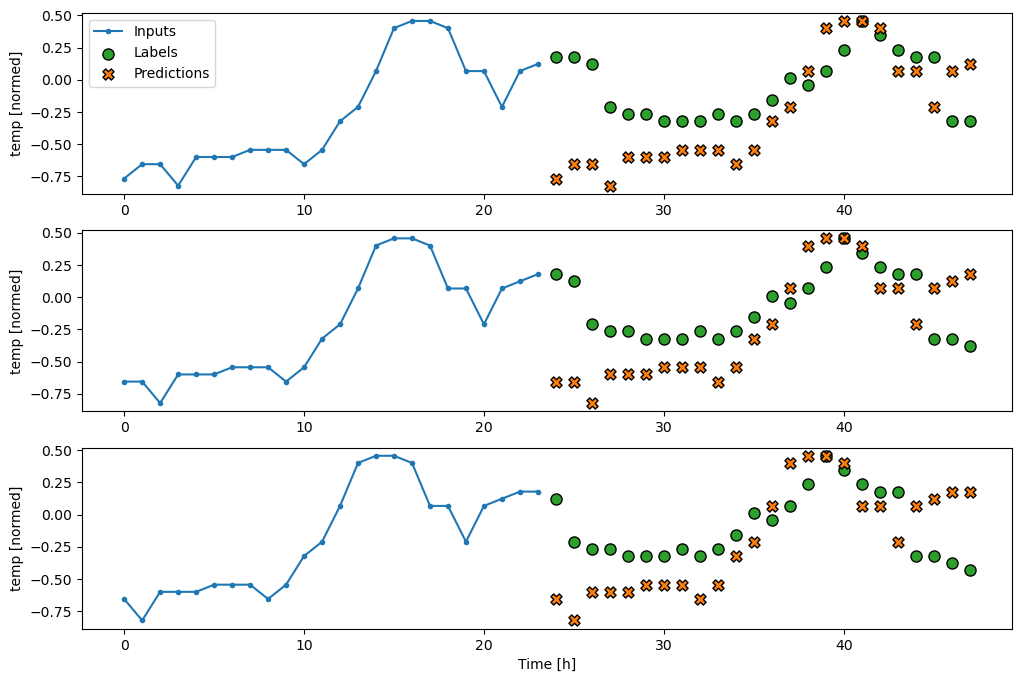

In [34]:
repeat_window = WindowGenerator(
    input_width=OUT_STEPS, label_width=OUT_STEPS, shift=OUT_STEPS,
    label_columns=['temp']
)

class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(repeat_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(repeat_window.test, verbose=0)
repeat_window.plot(repeat_baseline)

1115/1115 [==============================] - 18s 16ms/step - loss: 0.0683 - mean_absolute_error: 0.1878


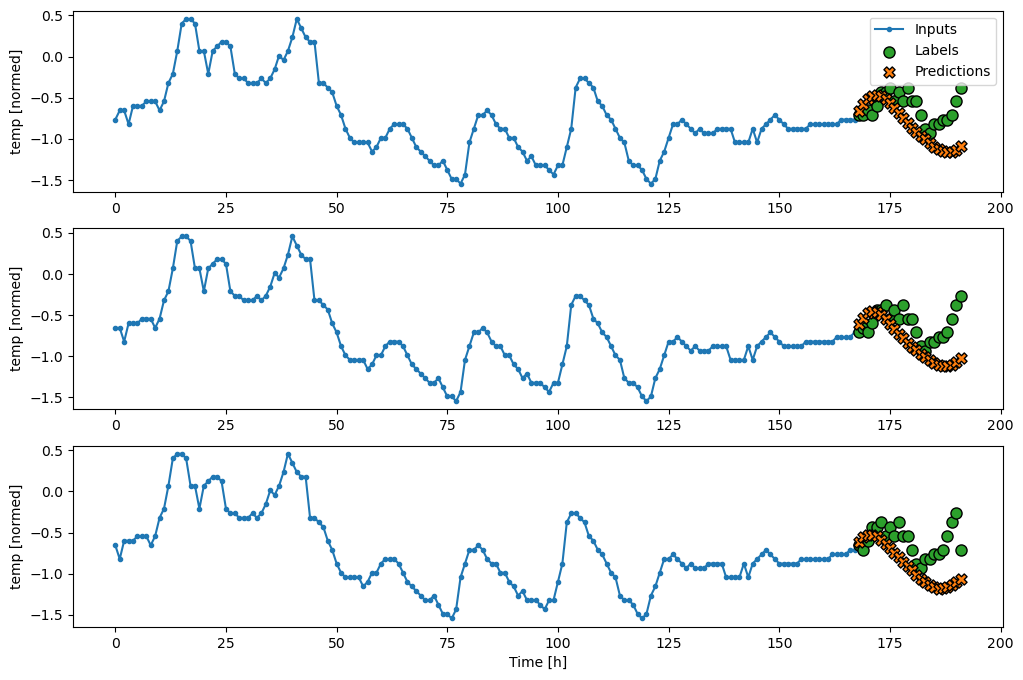

In [40]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    tf.keras.layers.Reshape([OUT_STEPS, 1])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

In [ ]:
# Comparing the forecasts with the actual values
yhat = [x[0] for x in model.predict(Xval)]
y = [y[0] for y in Yval]
# Creating the frame to store both predictions
days = df['obs_timestamp'].values[-len(y):]
frame = pd.concat([
 pd.DataFrame({'day': days, 'temp': y, 'type': 'original'}),
 pd.DataFrame({'day': days, 'temp': yhat, 'type': 'forecast'})
])
# Creating the unscaled values column
frame['temp_absolute'] = [(x * train_std['temp']) + train_mean['temp'] for x in frame['temp']]
# Pivoting
pivoted = frame.pivot_table(index='day', columns='type')
pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
pivoted['res'] = pivoted['temp_absolute_original'] - pivoted['temp_absolute_forecast']
pivoted['res_abs'] = [abs(x) for x in pivoted['res']]